A/A test to check if the groups are similar. Before starting the A/B experiment evaluation, we need to make sure that the splitting into groups went well and the groups are equal.

In [24]:
# Importing the libraries
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu
%matplotlib inline

In [25]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses' ,
    'password' : 'dpo_python_2020',
    'user' : 'student' ,
    'database' : 'simulator_20220720'
    }

Checking if the groups are correctly split

 Extracting the data from DB

Comparing the distributions visually

In [26]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-06-06' and toDate(time) <= '2022-06-12'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

In [27]:
df = ph.read_clickhouse(q, connection=connection)

In [28]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


In [29]:
df.groupby('exp_group')['user_id'].count()

exp_group
2    8480
3    8569
Name: user_id, dtype: int64

Comparing the groups visually by constructing the distribution graph

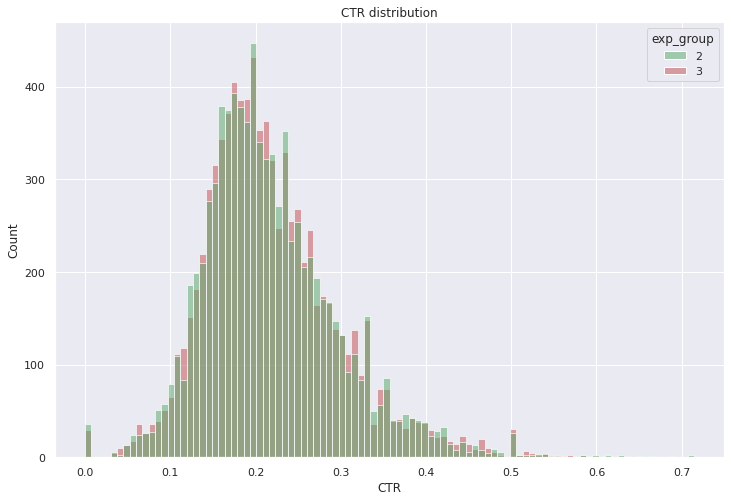

In [30]:
sns.set(rc={'figure.figsize':(12,8)})
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['g', 'r'],
              alpha=0.5,
              kde=False)
plt.title('CTR distribution')
plt.xlabel('CTR')
plt.show()

AA-test

Student's t-test

In [31]:
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

Student's t-test showed that p-value is higher than 0.05, thus, the difference between the means is not statistically significant. Let's use one more method.

Nonparametric bootstrap

Calculating 10000 pseudosampling without return for 500 users from experiemental group 2 and 3

In [32]:
p_values = []

In [33]:
for i in range(10000):
    subset2 = df[df.exp_group == 2].ctr.sample(500, replace=False).tolist()
    subset3 = df[df.exp_group == 3].ctr.sample(500, replace=False).tolist()

    p_values.append((stats.ttest_ind(subset2,
    subset3,
    equal_var=False)).pvalue)

In [34]:
stats.ttest_ind(subset2,
                subset3,
                equal_var=False)

Ttest_indResult(statistic=-1.1481834722834479, pvalue=0.25117102020230375)

Creating p-value distribution graph:

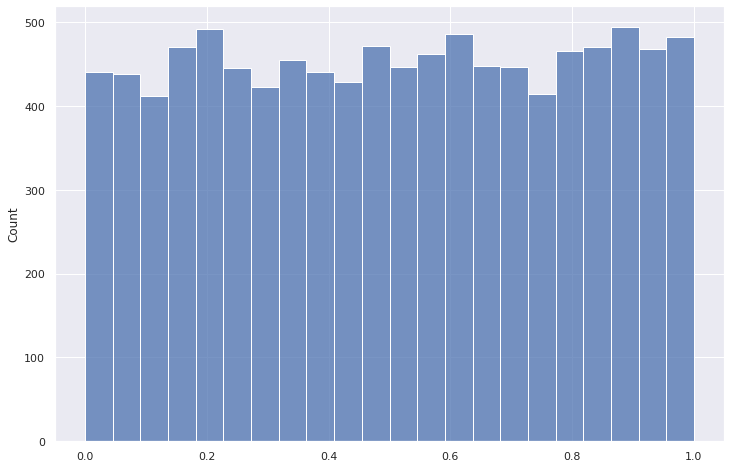

In [35]:
groups = sns.histplot(data = p_values)

Calculating the percent of p-values, that are less or equal to 0.05

In [36]:
a=100

In [37]:
b=len([item for item in p_values if item <= 0.05]) / len(p_values)

In [38]:
print(b * a)

4.91


Conclusion.
Splitting system works correctly, key metric is similar for experiemental groups 2 and 3.
We have used two methods to make sure the groups are equal.
1-st method: Visual check usign the distribution graph created for experiemental groups 2 and 3. We have also used Student's t-test, pvalue=0.45969873156476293. The groups are similar.

2nd method: We have performed simulation of 10000 AA-tests, in every iteration of this simulation we generated preudosampling without return for 500 users for users from experiemental groups 2 and 3, we compared these two preudosampling using Student's t-test.
We can accept null hypotesis if p_value < 0.05, thus, we can say that in approximately 5% of cases we can see statistically significant difference between experiemental groups 2 and 3. In our case p_value <=  0.05 in 4.91% cases, that means that splitting system is working correctly, as statistically significant difference can be seen only in cases of false positive results.